# Buses as a Graph (BaaG)

The OSMnx documentation states that: "[OSMnx is built on top of geopandas, networkx, and matplotlib](https://osmnx.readthedocs.io/en/stable/)." Being familiar with geopandas and matplotlib, I wanted to explore networkx.

I came across Roland Beck's [GTFStoGraph](https://github.com/Data-Monkey/GTFS-NetworkX/blob/master/GTFStoGraph.py), which unfortunately did not seem to perform well with SFMTA GTFS data even after some minor adjustments, so I wanted to find out if I could: 
1. Do the job in fewer lines of code
2. Get the code to perform more quickly
3. Use it in the context of San Francisco's [SFMTA GTFS](https://www.sfmta.com/reports/gtfs-transit-data)

## Required Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

## Data Preprocessing

In [2]:
'''
Reading in SFMTA GTFS data.
'''
SFMTA_trips = pd.read_csv('trips.txt', sep=",", header=0)
SFMTA_routes = pd.read_csv('routes.txt', sep=",", header=0)
SFMTA_stops = pd.read_csv('stops.txt', sep=",", header=0)
SFMTA_stop_times = pd.read_csv('stop_times.txt', sep=",", header=0)

'''
Merge data for easier route_short_name retrieval.
'''
SFMTA_trips = SFMTA_trips.merge(SFMTA_routes, how='left', on='route_id')

'''
Primary keys to dataframe index for easy recall.
'''
SFMTA_stops.index = SFMTA_stops['stop_id']
SFMTA_trips.index = SFMTA_trips['trip_id']

## Functions to build the graph

In [3]:
def add_stop_to_graph(G, stop_id):
    '''
    Adds stop as new node to graph.
    Attaches the name, lon, and lat as attributes for plotting.
    '''
    node = SFMTA_stops.loc[stop_id]
    
    if node['stop_id'] not in G.nodes:
        G.add_node(node['stop_id'],
                   stop_name = node['stop_name'],
                   stop_lon = node['stop_lon'],
                   stop_lat = node['stop_lat']
                  )
    return G

In [4]:
def add_edge_to_graph(G, from_id, to_id, route_short_name):
    '''
    Adds connection as new edge to graph.
    Attaches the name and count as attributes for plotting.
    Increase the count to know how many connections there are between the stops.
    '''
    edge = G.get_edge_data(SFMTA_stops.loc[from_id]['stop_id'],
                           SFMTA_stops.loc[to_id]['stop_id'],
                           route_short_name,
                           default=0
                          )
    if edge == 0:
        G.add_edge(SFMTA_stops.loc[from_id]['stop_id'],
                   SFMTA_stops.loc[to_id]['stop_id'],
                   key = route_short_name,
                   count = 1
                  )
    else:
        G.add_edge(SFMTA_stops.loc[from_id]['stop_id'],
                   SFMTA_stops.loc[to_id]['stop_id'],
                   key = route_short_name,
                   count = edge['count'] + 1
                  )

## Identify Edges to draw

In [5]:
'''
Identifying all the edges that need to be drawn.

Groups the dataframe by trip_id so that it cycle through
the stops that occur on a particular trip.

It then saves each pair of consecutive stop_id and
the route_short_name associated with it.
'''
edges = dict()

for trip_id, stop_time_iter in SFMTA_stop_times.groupby('trip_id'):
    if trip_id in SFMTA_trips['trip_id'].tolist():
        trip = SFMTA_trips.loc[trip_id]
        prev_stop = next(stop_time_iter.iterrows())[1]['stop_id']
        for stop_time in stop_time_iter[1:].iterrows():
            stop = stop_time[1]['stop_id']
            edge = (prev_stop, stop)
            edges[edge] = SFMTA_trips.loc[trip_id]['route_short_name']
            prev_stop = stop
print ('edges', len(edges))

edges 3999


## Building the graph 

In [6]:
G = nx.MultiGraph()

In [7]:
'''
Adds a node for each stop_id.
stop_id is dataset unique.
'''
for stop_id in SFMTA_stops['stop_id']:
    add_stop_to_graph(G, stop_id)
print('Nodes:', G.number_of_nodes())

Nodes: 3491


In [8]:
'''
Adds an edge for each pair of stop_id saved previously.
'''
for (start_stop_id, end_stop_id), route_short_name in edges.items():
    add_edge_to_graph(G, 
                      from_id = start_stop_id, 
                      to_id = end_stop_id, 
                      route_short_name = route_short_name)
print('Edges:', G.number_of_edges() )

Edges: 3999


In [9]:
'''
Gets some information for plotting purposes
'''
# degrees for each node in the graph
deg = nx.degree(G)

# retrieves the stop names for each stop
labels = {stop_id: G.node[stop_id]['stop_name'] if deg[stop_id] >= 0 else '' for stop_id in G.nodes}

# retrieves the stop_lon and stop_lan for each stop
pos = {stop_id: (G.node[stop_id]['stop_lon'], G.node[stop_id]['stop_lat']) for stop_id in G.nodes}

# assigns the appropriate crs for the dataset
data_crs = {'init': 'epsg:4326'}

## Visualising the graph

/Users/JiaHer/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


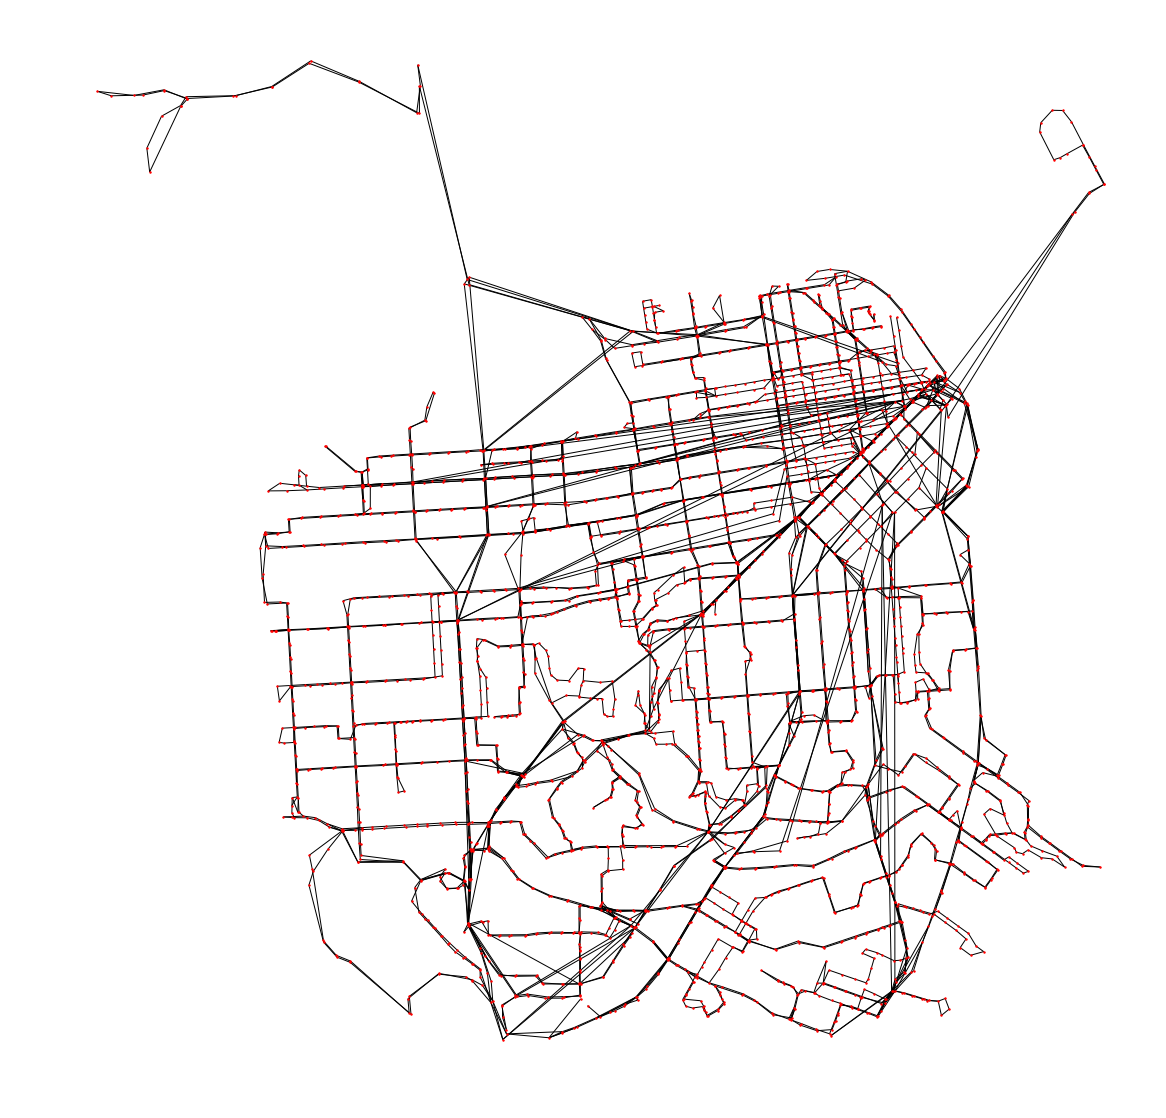

In [10]:
fig, ax = plt.subplots(figsize=(20,20))

nx.draw_networkx(G,
                 ax=ax,
                 with_labels=False,
                 labels=labels,
                 pos=pos,
                 node_size=2,
                 transform=data_crs
                )

ax.set_axis_off()

plt.show()

## Analysis

Visually, it looks very much like _Mapping San Francisco v1_. What is different is that there are clearly a number of connections beginning or ending in downtown San Francisco that stop less frequently, causing these long straight lines to cross the map.

What was interesting to see in the data was that the number of degrees for each node was fairly low (by printing the variable deg or edges/nodes plotted is equal to 3999/3491 = 1.15edge/node = avg 2.3degree/node). Most nodes had two degrees which can be explained by a transit vehicle arriving and leaving. I am somewhat surprised as I was under the impression that a stop might service more than one trip - the data and my assumptions warrant closer inspection.

Most stops come in pairs (in terms of proximity to each other and identical stop_names) which makes sense if the different stops represent stops on opposite sides of the street. I did however also notice that there were a number of clusters (more than two stops together) and I am curious if the data reflects reality or a result of the way in which the data is published. 

## Conclusion

Here are the three things I started out wanting to improve on:
1. **Do the job in fewer lines of code**
    * Success - It works now!
    * Success - [whitespace and comments all included] 124 lines of code vs 183 lines of code
        * Lines of code is not the primary metric of success but I'm still glad I could get rid of some redundancies
    * Success - The process is easier to follow with the comments I provide and fewer packages were used
        * Caveat: both projects were probably made with different audiences/purposes in mind
2. **Get the code to perform more quickly**
    * Unclear - Both ran in the same magnitude of time
        * I used pandas instead of dictionaries because I was curious to see how that would change the runtime. There is some good explanation [here](https://stackoverflow.com/questions/22084338/pandas-dataframe-performance) about under which circumstances dictionaries or dataframes might perform more quickly than the other.
3. **Use it in the context of San Francisco's [SFMTA GTFS](https://www.sfmta.com/reports/gtfs-transit-data)**
    * Success

## Extensions

The primary next steps I was thinking for this project was to **turn this from a .ipynb to a .py**. It would be nice and useful for this to go from the prototyping/exploration phase above to a clean executable python script. This would entail a number of next steps:
* Try this out on other GTFS datasets, does it still work?
* Check to see if the fields being called are requirements or optional under GTFS.
* Identify parameters that should be hard and soft coded.